# Tarea Redes Neuronales
Luis Roberto Cervantes Guevara

Para este proyecto se ha elegido crear una red neuronal que intente predecir el precio de Bitcoin utilizando la base de datos encontrada en Kaggle y la librería Keras.


El primer paso para esto es importar los datos del archivo csv descargado de Kaggle, así como empezar a manipularnos para crear dos arreglos con los que podamos trabajar. Para esto, es de mucha ayuda utilizar las librerías de pandas y numpy. como se muestra acontinuacón:

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
datos=pd.read_csv("PrecioBitcoin.csv")
dat=pd.DataFrame(datos)

In [2]:
datos.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


En esta visualización se observa que el set de datos contiene datos nulos, que para efectos de este proyecto es necesario quitar. Esto se puede hacer fácilmente con la función dropna() de pandas:

In [3]:
dat=dat.dropna()
dat=dat.reset_index()

In [4]:
dat

,index,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.000000,4.390000
1,478,1325346600,4.39,4.39,4.39,4.39,48.000000,210.720000,4.390000
2,547,1325350740,4.50,4.57,4.50,4.57,37.862297,171.380338,4.526411
3,548,1325350800,4.58,4.58,4.58,4.58,9.000000,41.220000,4.580000
4,1224,1325391360,4.58,4.58,4.58,4.58,1.502000,6.879160,4.580000
...,...,...,...,...,...,...,...,...,...
3613764,4857372,1617148560,58714.31,58714.31,58686.00,58686.00,1.384487,81259.372187,58692.753339
3613765,4857373,1617148620,58683.97,58693.43,58683.97,58685.81,7.294848,428158.146640,58693.226508
3613766,4857374,1617148680,58693.43,58723.84,58693.43,58723.84,1.705682,100117.070370,58696.198496
3613767,4857375,1617148740,58742.18,58770.38,58742.18,58760.59,0.720415,42332.958633,58761.866202


Para esta tarea, únicamente utilizaremos las columnas 'Timestamp' (que mide el tiempo) y 'Close', que es el precio del Bitcoin al cierre.

In [5]:
dat=dat.filter(items=['Timestamp','Close'])

Además, para entrenar esta red neuronal sólo trabajaremos con un subconjunto de estos valores, los de los últimos meses, dado que en ese intervalo había menor cantidad de valores nulos:

In [6]:
a=dat['Timestamp'].idxmax()
a

3613768

In [7]:
dat=dat[3600000:3613769].reset_index()
dat=dat.filter(items=['Timestamp','Close'])

Ahora, a partir de aquí es importante explicar cómo vamos a entrenar a nuestra red neuronal.
En un primer acercamiento al problema, la idea que tuve fue la de entrenarla usando únicamente los valores del tiempo y el precio, sin embargo, pronto me di cuenta que la dependencia del precio con tiempo era implícita si se procuraba no aleatorizar las listas; esa información ya estaba contenida en las listas ordenadas. Investigando, me di cuenta que una manera de realizar una predicción sobre un precio específico de esta moneda, llamémosle p_1, era considerando un subgrupo no muy grande de valores anteriores y estudiar cómo el comportamiento de éstos influye en p_1. Dado que el valor de las criptomonedas, las divisas y las acciones dependen de una cantidad enorme de variables, creo que para el análisis de los futuros valores de Bitcoin no es muy conveniente tomar todo el universo de los valores que ha tenido a lo largo de la historia. 

En concreto, en las siguientes líneas crearemos dos vectores que almacenen: 1.- los precios del Bitcoin ordenados temporalmente (llamado 'precio', y derivados) y 2.- un "vector" tal que cada entrada i de éste contenga las n cotizaciones inmediatas anteriores al valor precio[i] (llamodo 'auxiliar', y derivados). Se probaron varios valores para n, y para efectos de esta tarea, se dejará fija en n=200.

In [8]:
precio=dat.filter(items=['Close'])
auxiliar=dat.filter(items=['Close'])

El vector auxiliar se utilizará dentro de poco. Por ahora, separamos los conjuntos train y test:

In [9]:
filas=precio.idxmax()
precio_train=precio[:math.floor(filas*.8)].astype('float32')
auxiliar_train=auxiliar[:math.floor(filas*.8)].astype('float32')

In [10]:
precio_test=((precio[math.ceil(filas*.8):].reset_index()).filter(items=['Close'])).astype('float32')
auxiliar_test=((auxiliar[math.ceil(filas*.8):].reset_index()).filter(items=['Close'])).astype('float32')

Procedemos a normalizar:

In [11]:
ma=auxiliar.max()
mi=auxiliar.min()
j=ma-mi
auxiliar_trainn=(auxiliar_train-auxiliar.min())/j
auxiliar_testn=(auxiliar_test-auxiliar.min())/j
precio_trainn=auxiliar_trainn
precio_testn=auxiliar_testn

Ahora, crearemos un objeto que guarde los n precios anteriores de un precio p_i de Bitcoin:

In [12]:
precio_t=precio_trainn[200:]
auxiliar_t=[]
for i in range (0,auxiliar_trainn.shape[0]-200):
    auxiliar_t.append(auxiliar_trainn[i:i+200])

auxiliar_t=np.array(auxiliar_t)
precio_t=np.array(precio_t)

Para los datos de prueba:

In [13]:
precio_te=precio_testn[200:]
auxiliar_te=[]
for i in range (0,auxiliar_test.shape[0]-200):
    auxiliar_te.append(auxiliar_testn[i:i+200])

auxiliar_te=np.array(auxiliar_te)
precio_te=np.array(precio_te)

In [14]:
auxiliar_te = auxiliar_te.reshape(auxiliar_te.shape[0], auxiliar_te.shape[1])
auxiliar_t = auxiliar_t.reshape(auxiliar_t.shape[0], auxiliar_t.shape[1])

Antes de proseguir a entrenar nuestra red neuronal, creo que es útil visualizar qué se hizo en las líneas anteriores.
En la línea 11 teníamos los vectores auxiliar_trainn y precio_trainn (la doble n es porque están normalizados), que tienen dimensiones de:

In [15]:
auxiliar_trainn.shape,auxiliar_testn.shape

((10446, 1), (3322, 1))

In [16]:
precio_trainn.shape,precio_testn.shape

((10446, 1), (3322, 1))

En la línea 12 se crea un nuevo objeto, auxiliar_t, agrupe doscientos precios consecutivos de Bitcoin en cada entrada. También, se crea precio_t, que únicamente es la lista precio_trainn recorrida doscientos espacios, de tal manera que precio_t[0] es  precio_trainn[200] y precio_trainn[range(0,199)] es auxiliar[0]. Veámoslo:

In [17]:
auxiliar_t, auxiliar_t.shape

(array([[0.64165419, 0.65411902, 0.64455515, ..., 0.70994457, 0.71437532,
         0.70931758],
        [0.65411902, 0.64455515, 0.64829094, ..., 0.71437532, 0.70931758,
         0.70816207],
        [0.64455515, 0.64829094, 0.60872703, ..., 0.70931758, 0.70816207,
         0.70183989],
        ...,
        [0.58922806, 0.58758717, 0.58546047, ..., 0.64907827, 0.6483624 ,
         0.647074  ],
        [0.58758717, 0.58546047, 0.58566569, ..., 0.6483624 , 0.647074  ,
         0.65393472],
        [0.58546047, 0.58566569, 0.58773444, ..., 0.647074  , 0.65393472,
         0.65338833]]),
 (10246, 200))

In [18]:
precio_t, precio_t.shape


(array([[0.70816207],
        [0.70183989],
        [0.70085954],
        ...,
        [0.65393472],
        [0.65338833],
        [0.65086208]]),
 (10246, 1))

Observando cuidadosamente, podemos darnos cuenta que, por ejemplo, el valor 0.7708309 sería el valor que continuaría en el primer vector de auxiliar_t y que, esperamos, esté en gran medida determinado por esta entrada. 

Esta manera de acomodar los datos hace que sea muy sencillo crear una red neuronal con keras que, una vez entrenada, sólo necesite doscientos valores de precio consecutivos para predecir el valor del siguiente (que a su vez, formará parte de otro conjunto de doscientos precios asociados al precio número 202 y así consecutivamente).

In [19]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt

model = Sequential()
    
model.add(Dense(25, activation = 'tanh', input_shape=(200,)))
#model.add(Dense(10, activation = 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'linear'))

model.compile(loss='mean_squared_error',optimizer=Adam(lr=.00005))
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                5025      
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
Total params: 5,051
Trainable params: 5,051
Non-trainable params: 0
_________________________________________________________________


Donde nos dimos cuenta que el mejor optimizador para este ejercicio era Adam, al poder variar fácilmente el learning rate asociado.

In [20]:
history=model.fit(auxiliar_t, precio_t, 
          batch_size = 32,
          epochs = 100, 
          validation_data = (auxiliar_te, precio_te),
          shuffle=False)

Train on 10246 samples, validate on 3122 samples
Epoch 1/100
10246/10246 [==============================] - 1s 54us/step - loss: 0.1265 - val_loss: 0.0034
Epoch 2/100
10246/10246 [==============================] - 1s 71us/step - loss: 0.0210 - val_loss: 7.6437e-04
Epoch 3/100
10246/10246 [==============================] - 1s 76us/step - loss: 0.0063 - val_loss: 6.5989e-04
Epoch 4/100
10246/10246 [==============================] - 1s 73us/step - loss: 0.0057 - val_loss: 0.0014
Epoch 5/100
10246/10246 [==============================] - 1s 63us/step - loss: 0.0056 - val_loss: 0.0011
Epoch 6/100
10246/10246 [==============================] - 1s 59us/step - loss: 0.0053 - val_loss: 6.3134e-04
Epoch 7/100
10246/10246 [==============================] - 1s 76us/step - loss: 0.0053 - val_loss: 0.0014
Epoch 8/100
10246/10246 [==============================] - 1s 82us/step - loss: 0.0053 - val_loss: 7.4640e-04
Epoch 9/100
10246/10246 [==============================] - 1s 79us/step - loss: 0.0051 

En esto punto, sólo hace falta graficar y evaluar el rendimiento de la red usando los datos de prueba.

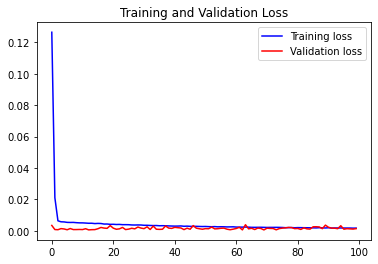

In [21]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()

plt.show()

[Text(-500.0, 0, ''),
 Text(0.0, 0, ''),
 Text(500.0, 0, ''),
 Text(1000.0, 0, ''),
 Text(1500.0, 0, ''),
 Text(2000.0, 0, ''),
 Text(2500.0, 0, ''),
 Text(3000.0, 0, ''),
 Text(3500.0, 0, '')]

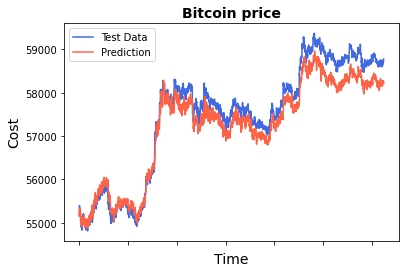

In [22]:
original = pd.DataFrame(precio_te)
predictions = pd.DataFrame(model.predict(auxiliar_te))

j=59371.86-50406.64
ax = sns.lineplot(x=original.index, y=(original[0]*j+50406.64), label="Test Data", color='royalblue')
ax = sns.lineplot(x=predictions.index, y=(predictions[0]*j+50406.64), label="Prediction", color='tomato')
ax.set_title('Bitcoin price', size = 14, fontweight='bold')
ax.set_xlabel("Time", size = 14)
ax.set_ylabel("Cost", size = 14)
ax.set_xticklabels('', size=10)

# Conclusión
En comparación al mercado de las divisas y acciones, las criptomonedas, al no estar reguladas por un órgano central, varían  muchísimo más, por lo que se hace más difícil predecir sus futuros valores observando la situación geopolítica. Aunque los resultados aquí presentados no son demasiado concluyentes, la realización de este trabajo me permitió darme cuenta cómo se puede utilizar un problema anterior (el de reconocimiento de digítos visto en clase) para abordar otro esencialmente diferente. El preprocesamiento de los datos hecho aquí, permitió darles a éstos la misma forma que tenían las imágenes de los digítos del ejercicio del curso, por loq que, en ese punto, el trabajo ya estaba hecho.